2025-06-28 07:30:03.638170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751095803.848601      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751095803.906843      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1751095818.767928      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751095818.768561      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

🔁 Round 1/30


I0000 00:00:1751095825.370005      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 2/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 3/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 4/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
🔁 Round 5/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 6/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 7/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 8/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 9/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
🔁 Round 10/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 11/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 15/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 16/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 17/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 18/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 19/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 20/30
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step
🔁 Round 21/30
8053/8053 ━━━━━━━━━━━━

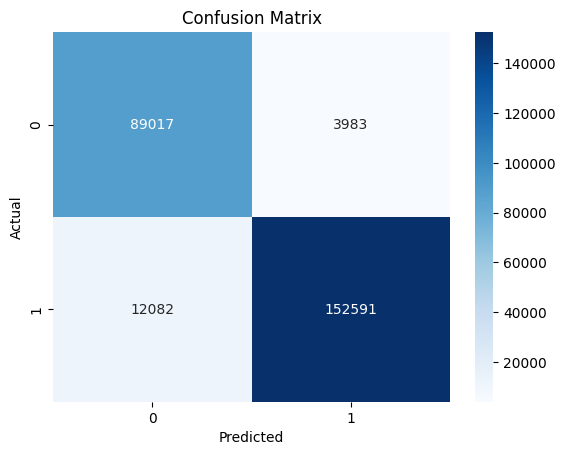

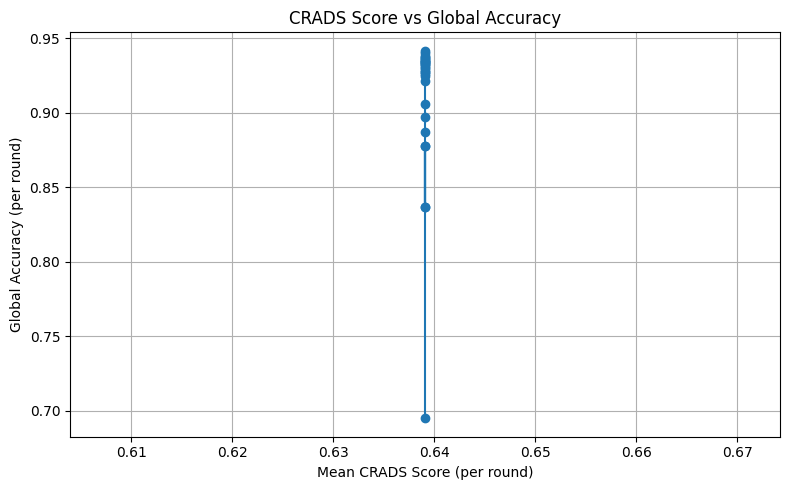

In [1]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve
from sklearn.utils import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Bidirectional, LSTM, GlobalAveragePooling1D, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Dataset ===
train_path = "/kaggle/input/dataset11/UNSW_NB15_training-set.csv"
test_path = "/kaggle/input/dataset11/UNSW_NB15_testing-set.csv"
df = pd.concat([pd.read_csv(train_path), pd.read_csv(test_path)], ignore_index=True)
df.columns = df.columns.str.strip()
df = df.select_dtypes(include=[np.number]).dropna()

X = df.drop(columns=['label'])
y = df['label'].astype(int)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === Client Splitting ===
num_clients = 5
client_data = []
size = len(X_scaled) // num_clients
for i in range(num_clients):
    s, e = i * size, (i + 1) * size if i < num_clients - 1 else len(X_scaled)
    Xc, yc = X_scaled[s:e], y[s:e]
    if len(Xc) > 0 and len(np.unique(yc)) > 1:
        client_data.append((Xc, yc))

# === CRADS Score ===
def crads_score(X, y):
    return y.sum() / len(y) if len(y) > 0 else 0

sorted_clients = sorted(client_data, key=lambda d: crads_score(d[0], d[1]), reverse=True)

# === Model Definition ===
def create_model(input_shape):
    lr_schedule = ExponentialDecay(0.001, decay_steps=1000, decay_rate=0.9)
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === FedProx Training ===
def fedprox_train(clients, global_weights, mu=0.01, epochs=5, batch_size=128):
    client_weights = []
    for Xc, yc in clients:
        if len(Xc) == 0:
            continue
        model = create_model((Xc.shape[1], 1))
        model.set_weights(global_weights)
        unique_classes = np.unique(yc)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_classes, y=yc)
            cw_dict = {int(unique_classes[0]): class_weights[0], int(unique_classes[1]): class_weights[1]}
        else:
            cw_dict = {int(unique_classes[0]): 1.0}
        model.fit(Xc.reshape(-1, Xc.shape[1], 1), yc, epochs=epochs, batch_size=batch_size, verbose=0, class_weight=cw_dict)
        client_weights.append(model.get_weights())
    new_weights = [np.mean(np.array(w), axis=0) for w in zip(*client_weights)]
    return new_weights

# === Federated Training ===
global_model = create_model((X.shape[1], 1))
global_weights = global_model.get_weights()
X_eval = X_scaled.reshape(-1, X.shape[1], 1)
crads_scores = []
round_accuracies = []

for rnd in range(30):
    print(f"🔁 Round {rnd+1}/30")
    global_model.set_weights(global_weights)
    global_weights = fedprox_train(sorted_clients, global_weights, mu=0.01, epochs=5)
    global_model.set_weights(global_weights)
    y_temp_pred = (global_model.predict(X_eval) > 0.4).astype(int).flatten()
    round_acc = accuracy_score(y, y_temp_pred)
    round_crads = np.mean([crads_score(Xc, yc) for Xc, yc in sorted_clients if len(Xc) > 0])
    round_accuracies.append(round_acc)
    crads_scores.append(round_crads)

# === Final Evaluation ===
global_model.set_weights(global_weights)
y_pred = (global_model.predict(X_eval) > 0.4).astype(int).flatten()
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
f2 = (1 + 2**2) * (prec * rec) / ((2**2 * prec) + rec)
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("\n📊 Classification Report:\n", classification_report(y, y_pred))
print("📉 Confusion Matrix:\n", cm)
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall: {rec:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ F2 Score: {f2:.4f}")
print(f"✅ FPR: {fpr:.4f}")
print(f"✅ FNR: {fnr:.4f}")

# === Plot Confusion Matrix ===
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === CRADS vs Accuracy ===
plt.figure(figsize=(8, 5))
plt.plot(crads_scores, round_accuracies, marker='o')
plt.xlabel("Mean CRADS Score (per round)")
plt.ylabel("Global Accuracy (per round)")
plt.title("CRADS Score vs Global Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# === Imports ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Bidirectional, LSTM, GlobalAveragePooling1D, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam

# === Load Data ===
df_train = pd.read_csv("/kaggle/input/dataset11/UNSW_NB15_training-set.csv")
df_test = pd.read_csv("/kaggle/input/dataset11/UNSW_NB15_testing-set.csv")
df = pd.concat([df_train, df_test], ignore_index=True)
df.columns = df.columns.str.strip()
df = df.select_dtypes(include=[np.number]).dropna()
print("✅ Loaded:", df.shape)

# === Feature-Label Split ===
X = df.drop(columns=['label'])
y = df['label'].astype(int)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === CRADS Client Splitting ===
num_clients = 5
client_data = []
size = len(X_scaled) // num_clients
for i in range(num_clients):
    start = i * size
    end = (i + 1) * size if i < num_clients - 1 else len(X_scaled)
    client_data.append((X_scaled[start:end], y[start:end]))

# CRADS Scoring
def crads_score(X, y):
    if len(y) == 0: return 0
    return y.sum() / len(y)

sorted_clients = sorted(client_data, key=lambda d: crads_score(d[0], d[1]), reverse=True)

# === CNN-LSTM Model ===
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === FedAvg Training ===
def fedavg_train(clients, global_weights, epochs=5, batch_size=128):
    client_weights = []
    for Xc, yc in clients:
        model = create_model((Xc.shape[1], 1))
        model.set_weights(global_weights)

        unique_classes = np.unique(yc)
        if len(unique_classes) == 2:
            class_weights = compute_class_weight('balanced', classes=unique_classes, y=yc)
            cw_dict = {int(unique_classes[0]): class_weights[0], int(unique_classes[1]): class_weights[1]}
        else:
            cw_dict = {int(unique_classes[0]): 1.0}

        model.fit(Xc.reshape(-1, Xc.shape[1], 1), yc, epochs=epochs, batch_size=batch_size,
                  verbose=0, class_weight=cw_dict)
        client_weights.append(model.get_weights())
    new_weights = []
    for weights in zip(*client_weights):
        new_weights.append(np.mean(np.array(weights), axis=0))
    return new_weights

# === Federated Rounds ===
global_model = create_model((X.shape[1], 1))
global_weights = global_model.get_weights()

for rnd in range(10):  # you can increase to 30 for full run
    print(f"🔁 Round {rnd+1}/10")
    global_model.set_weights(global_weights)
    global_weights = fedavg_train(sorted_clients, global_weights, epochs=5)

# === Evaluation ===
global_model.set_weights(global_weights)
X_eval = X_scaled.reshape(-1, X.shape[1], 1)
y_pred = (global_model.predict(X_eval) > 0.5).astype(int).flatten()

# === Metrics ===
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
f2 = (1 + 2**2) * (prec * rec) / ((4 * prec) + rec)
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

# === Output ===
print(f"\n📊 Classification Report:\n{classification_report(y, y_pred)}")
print("📉 Confusion Matrix:\n", cm)
print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall: {rec:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ F2 Score: {f2:.4f}")
print(f"✅ FPR: {fpr:.4f}")
print(f"✅ FNR: {fnr:.4f}")


✅ Loaded: (257673, 41)
🔁 Round 1/10
🔁 Round 2/10
🔁 Round 3/10
🔁 Round 4/10
🔁 Round 5/10
🔁 Round 6/10
🔁 Round 7/10
🔁 Round 8/10
🔁 Round 9/10
🔁 Round 10/10
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     93000
           1       0.95      0.94      0.95    164673

    accuracy                           0.93    257673
   macro avg       0.93      0.93      0.93    257673
weighted avg       0.93      0.93      0.93    257673

📉 Confusion Matrix:
 [[ 85318   7682]
 [  9638 155035]]
✅ Accuracy: 0.9328
✅ Precision: 0.9528
✅ Recall: 0.9415
✅ F1 Score: 0.9471
✅ F2 Score: 0.9437
✅ FPR: 0.0826
✅ FNR: 0.0585


In [6]:
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# === Select a small sample for explanation ===
X_sample = X_scaled[:100]
X_sample_3d = X_sample.reshape(-1, X.shape[1], 1)

# === Wrapper for 3D model input ===
def model_2d_predict(x):
    x_reshaped = x.reshape(-1, X.shape[1], 1)
    return global_model.predict(x_reshaped)

# === SHAP Explainer ===
explainer_shap = shap.Explainer(model_2d_predict, X_sample)
shap_values = explainer_shap(X_sample)

# === Save SHAP Summary Plot ===
print("✅ SHAP Summary Plot Saved...")

plt.figure(figsize=(10, 6))  # Optional: Resize
shap.summary_plot(shap_values, X_sample, feature_names=X.columns.tolist(), show=False)
plt.tight_layout()
plt.savefig("shap_summary_plot_highres.png", dpi=600, bbox_inches='tight')  # Save as PNG
plt.close()  # Close the plot to avoid re-display in notebook


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   3%|▎         | 3/100 [00:00<?, ?it/s]

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   5%|▌         | 5/100 [00:17<03:37,  2.29s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   6%|▌         | 6/100 [00:21<04:46,  3.05s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   7%|▋         | 7/100 [00:25<05:24,  3.48s/it]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   8%|▊         | 8/100 [00:29<05:36,  3.66s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:   9%|▉         | 9/100 [00:33<05:47,  3.82s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  10%|█         | 10/100 [00:38<05:59,  3.99s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  11%|█         | 11/100 [00:42<05:58,  4.02s/it]

175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  12%|█▏        | 12/100 [00:46<05:59,  4.08s/it]

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  13%|█▎        | 13/100 [00:50<06:02,  4.17s/it]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  14%|█▍        | 14/100 [00:54<05:54,  4.12s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  15%|█▌        | 15/100 [00:58<05:50,  4.13s/it]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  16%|█▌        | 16/100 [01:02<05:42,  4.07s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  17%|█▋        | 17/100 [01:06<05:35,  4.04s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  18%|█▊        | 18/100 [01:11<05:34,  4.08s/it]

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  19%|█▉        | 19/100 [01:15<05:41,  4.21s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  20%|██        | 20/100 [01:19<05:35,  4.19s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  21%|██        | 21/100 [01:23<05:30,  4.18s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  22%|██▏       | 22/100 [01:27<05:24,  4.17s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  23%|██▎       | 23/100 [01:32<05:23,  4.20s/it]

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  24%|██▍       | 24/100 [01:37<05:31,  4.36s/it]

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  25%|██▌       | 25/100 [01:41<05:25,  4.35s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  26%|██▌       | 26/100 [01:45<05:17,  4.29s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  27%|██▋       | 27/100 [01:49<05:09,  4.24s/it]

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  28%|██▊       | 28/100 [01:53<05:00,  4.17s/it]

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  29%|██▉       | 29/100 [01:57<04:55,  4.16s/it]

186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  30%|███       | 30/100 [02:02<04:55,  4.22s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  31%|███       | 31/100 [02:05<04:41,  4.08s/it]

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  32%|███▏      | 32/100 [02:10<04:51,  4.29s/it]

181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  33%|███▎      | 33/100 [02:15<04:49,  4.32s/it]

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  34%|███▍      | 34/100 [02:19<04:48,  4.37s/it]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  35%|███▌      | 35/100 [02:23<04:30,  4.17s/it]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  36%|███▌      | 36/100 [02:27<04:29,  4.21s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  37%|███▋      | 37/100 [02:32<04:32,  4.32s/it]

150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  38%|███▊      | 38/100 [02:35<04:16,  4.14s/it]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  39%|███▉      | 39/100 [02:39<04:10,  4.11s/it]

170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  40%|████      | 40/100 [02:44<04:10,  4.17s/it]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  41%|████      | 41/100 [02:48<04:08,  4.21s/it]

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  42%|████▏     | 42/100 [02:52<04:02,  4.19s/it]

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  43%|████▎     | 43/100 [02:57<04:06,  4.33s/it]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  44%|████▍     | 44/100 [03:01<03:52,  4.15s/it]

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  45%|████▌     | 45/100 [03:05<03:55,  4.28s/it]

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  46%|████▌     | 46/100 [03:10<03:56,  4.37s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  47%|████▋     | 47/100 [03:15<03:59,  4.51s/it]

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  48%|████▊     | 48/100 [03:19<03:47,  4.37s/it]

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  49%|████▉     | 49/100 [03:23<03:45,  4.43s/it]

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  50%|█████     | 50/100 [03:28<03:41,  4.43s/it]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  51%|█████     | 51/100 [03:31<03:26,  4.22s/it]

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  52%|█████▏    | 52/100 [03:36<03:24,  4.26s/it]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  53%|█████▎    | 53/100 [03:40<03:17,  4.21s/it]

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  54%|█████▍    | 54/100 [03:44<03:11,  4.17s/it]

168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  55%|█████▌    | 55/100 [03:48<03:09,  4.20s/it]

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  56%|█████▌    | 56/100 [03:52<02:58,  4.06s/it]

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  57%|█████▋    | 57/100 [03:56<02:58,  4.14s/it]

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  58%|█████▊    | 58/100 [04:01<02:58,  4.25s/it]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  59%|█████▉    | 59/100 [04:05<02:50,  4.17s/it]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  60%|██████    | 60/100 [04:08<02:43,  4.09s/it]

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  61%|██████    | 61/100 [04:12<02:34,  3.96s/it]

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  62%|██████▏   | 62/100 [04:17<02:38,  4.16s/it]

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  63%|██████▎   | 63/100 [04:21<02:34,  4.16s/it]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  64%|██████▍   | 64/100 [04:25<02:29,  4.15s/it]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  65%|██████▌   | 65/100 [04:29<02:26,  4.18s/it]

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  66%|██████▌   | 66/100 [04:34<02:25,  4.28s/it]

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  67%|██████▋   | 67/100 [04:38<02:19,  4.21s/it]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  68%|██████▊   | 68/100 [04:42<02:12,  4.14s/it]

171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  69%|██████▉   | 69/100 [04:46<02:08,  4.13s/it]

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  70%|███████   | 70/100 [04:51<02:09,  4.32s/it]

166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  71%|███████   | 71/100 [04:55<02:02,  4.23s/it]

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  72%|███████▏  | 72/100 [04:59<01:57,  4.20s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  73%|███████▎  | 73/100 [05:03<01:50,  4.08s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  74%|███████▍  | 74/100 [05:08<01:53,  4.35s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  75%|███████▌  | 75/100 [05:12<01:45,  4.22s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  76%|███████▌  | 76/100 [05:16<01:39,  4.14s/it]

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


PermutationExplainer explainer:  77%|███████▋  | 77/100 [05:20<01:36,  4.21s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  78%|███████▊  | 78/100 [05:24<01:31,  4.14s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  79%|███████▉  | 79/100 [05:28<01:25,  4.06s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  80%|████████  | 80/100 [05:31<01:18,  3.95s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  81%|████████  | 81/100 [05:35<01:14,  3.90s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  82%|████████▏ | 82/100 [05:39<01:09,  3.84s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  83%|████████▎ | 83/100 [05:43<01:04,  3.82s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  84%|████████▍ | 84/100 [05:46<01:00,  3.81s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  85%|████████▌ | 85/100 [05:50<00:57,  3.81s/it]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  86%|████████▌ | 86/100 [05:54<00:54,  3.88s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  87%|████████▋ | 87/100 [05:58<00:49,  3.84s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  88%|████████▊ | 88/100 [06:02<00:45,  3.80s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  89%|████████▉ | 89/100 [06:06<00:41,  3.79s/it]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  90%|█████████ | 90/100 [06:09<00:37,  3.77s/it]

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  91%|█████████ | 91/100 [06:13<00:34,  3.78s/it]

153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  92%|█████████▏| 92/100 [06:17<00:30,  3.79s/it]

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  93%|█████████▎| 93/100 [06:21<00:27,  3.97s/it]

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  94%|█████████▍| 94/100 [06:25<00:23,  3.99s/it]

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  95%|█████████▌| 95/100 [06:30<00:21,  4.22s/it]

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  96%|█████████▌| 96/100 [06:34<00:16,  4.04s/it]

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  97%|█████████▋| 97/100 [06:37<00:11,  3.94s/it]

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  98%|█████████▊| 98/100 [06:41<00:07,  3.88s/it]

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer:  99%|█████████▉| 99/100 [06:46<00:04,  4.13s/it]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 100%|██████████| 100/100 [06:50<00:00,  4.05s/it]

161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


PermutationExplainer explainer: 101it [06:54,  4.23s/it]                         

✅ SHAP Summary Plot Saved...



The figure layout has changed to tight


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


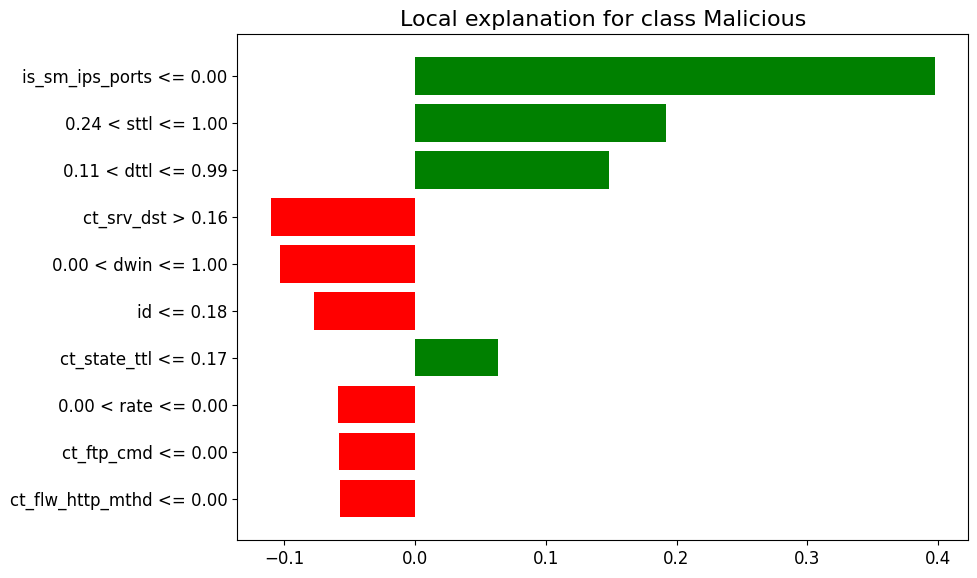

In [4]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# === Wrapper: LIME expects 2D array of probabilities [P(benign), P(malicious)] ===
def model_2d_predict_lime(x):
    preds = global_model.predict(x.reshape(-1, X.shape[1], 1))
    return np.hstack((1 - preds, preds))

# === Initialize LIME Tabular Explainer ===
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=X.columns.tolist(),
    class_names=["Benign", "Malicious"],
    mode='classification'
)

# === Choose a sample to explain ===
sample_index = 5  # Change this to any index (0 to len(X_scaled)-1)
exp = explainer_lime.explain_instance(
    data_row=X_scaled[sample_index],
    predict_fn=model_2d_predict_lime,
    num_features=10
)

# === Improve figure quality settings ===
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# === Generate and save figure ===
fig = exp.as_pyplot_figure()
fig.tight_layout()
fig.savefig("lime_sample_explanation_highres.png", dpi=600, bbox_inches='tight')
plt.show()


8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 1 | CRADS: 0.8980 | Accuracy: 0.6391
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 2 | CRADS: 0.8980 | Accuracy: 0.6531
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 3 | CRADS: 0.8980 | Accuracy: 0.7560
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 4 | CRADS: 0.8980 | Accuracy: 0.6719
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 5 | CRADS: 0.8980 | Accuracy: 0.7194
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 6 | CRADS: 0.8980 | Accuracy: 0.7627
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 7 | CRADS: 0.8980 | Accuracy: 0.7356
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 8 | CRADS: 0.8980 | Accuracy: 0.8445
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
🔁 Round 9 | CRADS: 0.8980 | Accuracy: 0.8124
8053/8053 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
🔁 Round 10 | CRADS: 0.8980 | Accuracy: 0.8247


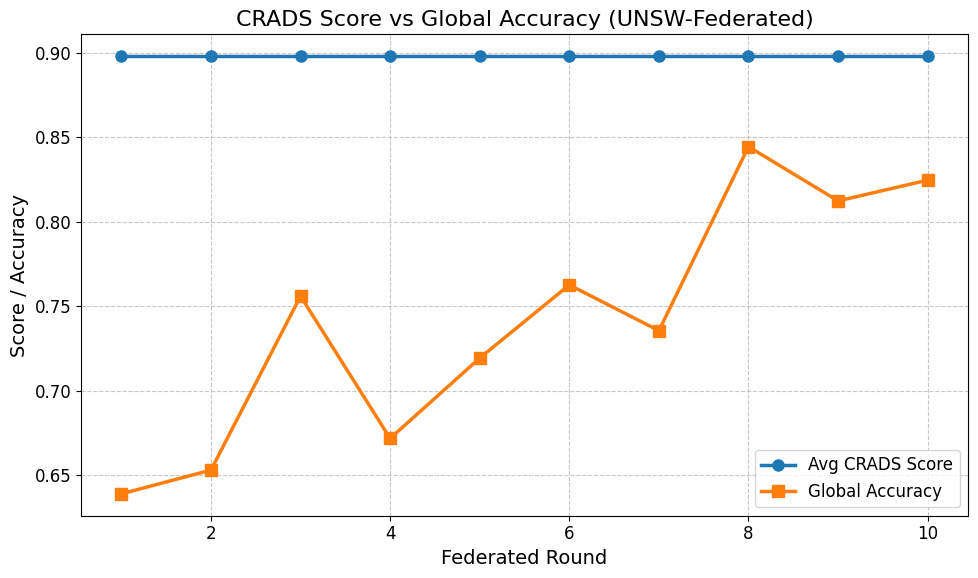

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Bidirectional, LSTM, GlobalAveragePooling1D, Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam

# === Load Data ===
train_path = "/kaggle/input/dataset11/UNSW_NB15_training-set.csv"
test_path = "/kaggle/input/dataset11/UNSW_NB15_testing-set.csv"
df = pd.concat([pd.read_csv(train_path), pd.read_csv(test_path)], ignore_index=True)
df.columns = df.columns.str.strip()
df = df.select_dtypes(include=[np.number]).dropna()

# === Preprocessing ===
X = df.drop(columns=['label'])
y = df['label'].astype(int)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === Client Splitting (5 clients) ===
client_data = []
size = len(X_scaled) // 5
for i in range(5):
    start, end = i * size, (i + 1) * size if i < 4 else len(X_scaled)
    client_data.append((X_scaled[start:end], y[start:end]))

# === CRADS Score ===
def crads_score(X, y):
    return y.sum() / len(y)

sorted_clients = sorted(client_data, key=lambda d: crads_score(d[0], d[1]), reverse=True)

# === Model Architecture ===
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.0007), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# === FedProx Training ===
def fedprox_train(clients, global_weights, mu=0.01, epochs=3, batch_size=128):
    weights = []
    for Xc, yc in clients:
        model = create_model((Xc.shape[1], 1))
        model.set_weights(global_weights)
        model.fit(Xc.reshape(-1, Xc.shape[1], 1), yc, epochs=epochs, batch_size=batch_size, verbose=0)
        weights.append(model.get_weights())
    # FedProx just uses FedAvg weights here; if needed, mu-based penalty can be added for real FedProx.
    return [np.mean([w[i] for w in weights], axis=0) for i in range(len(global_weights))]

# === Federated Rounds ===
global_model = create_model((X.shape[1], 1))
global_weights = global_model.get_weights()
round_crads_scores = []
round_accuracies = []

for rnd in range(10):
    selected_clients = sorted_clients[:3]
    avg_crads = np.mean([crads_score(X, y) for X, y in selected_clients])
    global_model.set_weights(global_weights)
    global_weights = fedprox_train(selected_clients, global_weights, mu=0.01, epochs=3)
    global_model.set_weights(global_weights)
    y_pred = (global_model.predict(X_scaled.reshape(-1, X.shape[1], 1)) > 0.5).astype(int).flatten()
    acc = accuracy_score(y, y_pred)
    round_crads_scores.append(avg_crads)
    round_accuracies.append(acc)
    print(f"🔁 Round {rnd+1} | CRADS: {avg_crads:.4f} | Accuracy: {acc:.4f}")

# === High-Quality Plot ===
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), round_crads_scores, label="Avg CRADS Score", marker='o', linewidth=2.5, markersize=8)
plt.plot(range(1, 11), round_accuracies, label="Global Accuracy", marker='s', linewidth=2.5, markersize=8)
plt.xlabel("Federated Round", fontsize=14)
plt.ylabel("Score / Accuracy", fontsize=14)
plt.title("CRADS Score vs Global Accuracy (UNSW-Federated)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("crads_vs_accuracy_highres.png", dpi=600, bbox_inches='tight')
plt.show()
